In [30]:
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
import plotly.express as px
from matplotlib import pyplot as plt
import math
import cv2
from skimage.draw import polygon

In [86]:
"""https://colab.research.google.com/drive/1AkBpCFU7nW_WLbeKudcLlZD-ZK5DuQCj"""
data_path = "../data/satellite-data-6d.csv"

SCALE = 100
MAX_X = 360*SCALE
MAX_Y = 180*SCALE

In [74]:
### """constants"""
def get_satellite_view_distance(satellite_fov=5):
    earth_radius = 6371000 # earth radius in meters
    earth_circumference = 2 * np.pi * earth_radius # earth circumference in meters
    earth_max_x = earth_circumference
    earth_max_y = earth_circumference / 2
    satellite_distance = 500000 # distance of the satellite in meters
    satellite_fov_rad = satellite_fov * np.pi / 180 # satellite fov in radians
    satellite_view = 2 * np.tan(satellite_fov_rad/2) * satellite_distance
    scale_view = satellite_view / 5 # scale view area in meters
    grid_size = scale_view # grid size in meters
    return satellite_view

In [5]:
# read csv data
df = pd.read_csv(data_path)
df_columns_org = list(df.columns)
df_columns_org

df.drop(df_columns_org[3:], axis=1, inplace=True)

new_columns_names = ["Time","Latitude","Longitude"]
df.columns = new_columns_names
df.head()

Time  Latitude  Longitude
0  21 Aug 2022 07:30:00.000    -0.000    -82.105
1  21 Aug 2022 07:30:10.000     0.523    -81.784
2  21 Aug 2022 07:30:20.000     1.046    -81.462
3  21 Aug 2022 07:30:30.000     1.569    -81.140
4  21 Aug 2022 07:30:40.000     2.091    -80.818

In [6]:
def get_map(zoom=12, center=None):
    return folium.Map(zoom_start = zoom)

#Display the map
my_map = get_map()

In [7]:
def draw_points_on_map(df, map_object, color):
    for index, row in df.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=1,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=row['Time'],
            tooltip=row['Time']
        ).add_to(map_object)
    return map_object

In [7]:
# map_object = draw_points_on_map(df, my_map, 'red')
# map_object

In [8]:
def Lat_to_meter(lat):
    return lat * 110574
def Lon_to_meter(lon,lat):
    return lon * 111320 * np.cos((lat*np.pi)/180)
def meter_to_lat(meter):
    return meter / 110574
def meter_to_lon(meter,lat):
    return meter / (111320 * np.cos((lat*np.pi)/180))

In [88]:
# convertions
def get_new_coordinates(point, angle,distance,left=True):
    """
             line
             /
            / angle
         point -------
          /
         /
        we want new point with custom distance that is perpendicular to the line
    """
    # print("point",point)
    # print("angle",angle)
    # print("distance",distance)
    x = distance * np.cos(np.pi - ((angle * np.pi) / 180))
    y = distance * np.sin(np.pi - ((angle * np.pi) / 180))
    return (point[0] - x,y+point[1]) if left else (point[0] + x,point[1] - y)

def distance_to_lat_long(distance):
    lat = meter_to_lat(distance)
    lon = meter_to_lon(distance,lat)
    # print("in degree => ",lat,lon)
    return lat,lon

def get_two_bound(distance, angle,point=(0,0)):
    lat1,lon1 = get_new_coordinates(point, angle, distance)
    lat2,lon2 = get_new_coordinates(point, angle, distance, left=False)
    return [lat1,lon1],[lat2,lon2]

def get_points(distance, angle,point=(0,0),prev_point=None):
    if (prev_point is not None):
        # print("y diff => ",point[1]-prev_point[1])
        angle = angle if point[1]>prev_point[1] else 90 + angle
        # print("angle => ",angle)
        lt,ln = distance_to_lat_long(distance)
        distance_in_lat_lon = np.sqrt(lt**2+ln**2)*SCALE
        # print("distance in lat long",distance_in_lat_lon)
        ponit1,point2 = get_two_bound(distance_in_lat_lon/2, angle,point)
        return [ponit1,point2,angle]
    else:
        lt,ln = distance_to_lat_long(distance)
        distance_in_lat_lon = np.sqrt(lt**2+ln**2)*SCALE
        print("distance in lat long",distance_in_lat_lon)
        point1,point2 = get_two_bound(distance_in_lat_lon/2, angle,point)
        return [point1,point2,angle]



In [89]:
# test
sample_row = df.iloc[0]
test_point = (sample_row['Latitude'], sample_row['Longitude'])
distance = get_satellite_view_distance()
point1,point2,_ = get_points(distance,55,test_point)

print(f"distance: {distance}")
print(f"test ponit: {test_point}")
print(f"point1: {point1}")
print(f"point2: {point2}")

distance: 43660.94290851206
test ponit: (-0.0, -82.105)
point1: [15.961229264439135, -59.31000224083735]
point2: [-15.961229264439135, -104.89999775916266]


In [90]:
def get_point_dict(point=(0,0),angle=0,distance=0):
    return {
        "point": point,
        "angle": angle,
        "distance": distance
    }


In [91]:
left_points = []
right_points = []
main_points = []
distance = get_satellite_view_distance()
angle = 55
prev_point = df.iloc[0]
for index, row in df.iterrows():
    point = (row[new_columns_names[1]], row[new_columns_names[2]])
    point1,point2,_ = get_points(distance,angle,point,prev_point)
    left_points.append(get_point_dict(point1,angle,distance))
    right_points.append(get_point_dict(point2,angle,distance))
    main_points.append(get_point_dict(point,angle,distance))

In [ ]:
new_map = get_map()
for index in range(len(main_points)):
    folium.CircleMarker(
        location=main_points[index]["point"],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=main_points[index]["point"],
        tooltip=main_points[index]["angle"]
    ).add_to(new_map)
    folium.CircleMarker(
        location=left_points[index]["point"],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=left_points[index]["point"],
        tooltip=left_points[index]["angle"]
    ).add_to(new_map)
    folium.CircleMarker(
        location=right_points[index]["point"],
        radius=1,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        popup=right_points[index]["point"],
        tooltip=right_points[index]["angle"]
    ).add_to(new_map)

new_map

In [92]:
new_map = get_map()
# draw line for each ponit group
folium.PolyLine(locations=list(map(lambda p:p["point"],main_points)),color='red').add_to(new_map)
folium.PolyLine(locations=list(map(lambda p:p["point"],left_points)),color='blue').add_to(new_map)
folium.PolyLine(locations=list(map(lambda p:p["point"],right_points)),color='green').add_to(new_map)
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(new_map)
new_map

In [59]:
# matrix map

earth_map = np.zeros((MAX_X, MAX_Y), dtype=np.uint8)

In [60]:
def plot_earth_map(earth_map):
    plt.matshow(earth_map, cmap='gray')
    plt.xlim(0,MAX_X)
    plt.ylim(0,MAX_Y)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

def fill_area_points(earth,points,limit):
    # we want to fill the area that is between two points y with x limit
    x1,y1 = int(points[0][0]),int(points[0][1])
    x2,y2 = int(points[1][0]),int(points[1][1])
    # print("xys => ",x1,y1,x2,y2)
    if y1>y2:
        y2,y1 = y1,y2
        x2,x1 = x1,x2
    for y in range(y1,y2):
        # y = y1 + m * (x - x1) => x = x1 + (y - y1) / m
        m = int((y2-y1)/(x2-x1))
        x = x1 if m == 0 else int(x1 + (y-y1)/m)
        # print("x,y => ",x,y)
        # print("limit => ",int(x)-limit,",",int(x)+limit)
        for xx in range(int(x)-limit,int(x)+limit):
            earth[xx%MAX_X,y%MAX_Y] += 100
            # print("xx,y => ",xx,y)
        # print("-----------------")
    return earth

def fill_earth_map(earth,df):
    limit = get_satellite_view_distance()/2
    # print("limit => ",limit)
    lt,ln = distance_to_lat_long(limit)
    lt = math.ceil(lt)*SCALE
    ln = math.ceil(ln)*SCALE
    limit = int(np.sqrt(lt**2+ln**2))
    # print("limit => ",limit)
    for i in range(df.shape[0]-2):
        point1 = [df.iloc[i]['Longitude'],df.iloc[i]['Latitude']]
        point2 = [df.iloc[i+1]['Longitude'],df.iloc[i+1]['Latitude']]
        point1[0] = point1[0]*SCALE+MAX_X//2
        point1[1] = point1[1]*SCALE+MAX_Y//2
        point2[0] = point2[0]*SCALE+MAX_X//2
        point2[1] = point2[1]*SCALE+MAX_Y//2
        # print("point1,point2 => ",point1,point2)
        if int(point1[1]) == int(point2[1]):
            continue
        else :
            earth = fill_area_points(earth,(point1,point2),limit)
    return earth

In [ ]:
new_earth = fill_earth_map(earth_map,df)
print(new_earth.shape)

In [18]:
print(f"map size as GB => {new_earth.nbytes/(1024*1024*1024)}")

map size as GB => 0.006034970283508301


(1800, 3600)


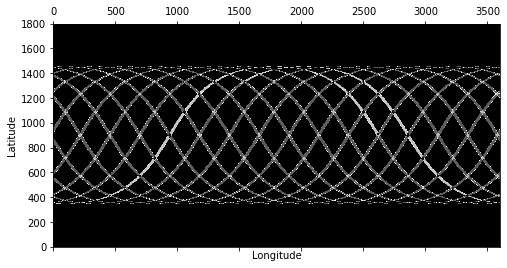

In [19]:
rotated = np.rot90(new_earth,3)
print(rotated.shape)
plot_earth_map(rotated)

In [21]:
max_val = 0
for i in range(rotated.shape[0]):
    for j in range(rotated.shape[1]):
        if rotated[i][j] > max_val:
            max_val = rotated[i][j]
            print(f"i,j => {(i,j)}, max_val => {max_val}")

i,j => (348, 48), max_val => 100
i,j => (348, 51), max_val => 200
i,j => (348, 55), max_val => 244


In [25]:
earth_map_mat = cv2.Mat(rotated)

In [26]:
cv2.imwrite("earth_map.png",earth_map_mat)

True

In [62]:
earth_map_mat = cv2.Mat(np.zeros((MAX_X, MAX_Y), dtype=np.uint8))

In [37]:
img = np.zeros((20, 20), dtype=np.uint8)
vertices = np.array([
    [5,5],
    [5,15],
    [15,15],
    [15,5],
])
print(vertices)
print(vertices[:,0])
rr, cc = polygon(vertices[:,0], vertices[:,1], img.shape)
img[rr,cc] = 100

print(img.shape)

img = cv2.Mat(img)
cv2.imwrite("test_map.png",img)

[[ 5  5]
 [ 5 15]
 [15 15]
 [15  5]]
[ 5  5 15 15]
(20, 20)


True

In [84]:
def fill_earth(df,earth):
    limit = (get_satellite_view_distance())
    print("limit => ",limit)
    for i in range(df.shape[0]-2):
        point1 = [df.iloc[i][new_columns_names[2]],df.iloc[i][new_columns_names[1]]]
        point2 = [df.iloc[i+1][new_columns_names[2]],df.iloc[i+1][new_columns_names[1]]]
        point1[0] = point1[0]*SCALE+MAX_X//2
        point1[1] = point1[1]*SCALE+MAX_Y//2
        point2[0] = point2[0]*SCALE+MAX_X//2
        point2[1] = point2[1]*SCALE+MAX_Y//2
        if int(point1[1]) <= int(point2[1]):
            angle = 45
            top_1,top_2,_ = get_points(limit,angle,point2)
            top_1[0] = int(top_1[0])
            top_1[1] = int(top_1[1])
            top_2[0] = int(top_2[0])
            top_2[1] = int(top_2[1])
            bottom_1,bottom_2,_ = get_points(limit,angle,point1)
            bottom_1[0] = int(bottom_1[0])
            bottom_1[1] = int(bottom_1[1])
            bottom_2[0] = int(bottom_2[0])
            bottom_2[1] = int(bottom_2[1])
            points = np.array([top_1,top_2,bottom_1,bottom_2])
            # print("points 45 => ",points)
            # print("points[:,0] => ",points[:,0])
            rr, cc = polygon(points[:,0], points[:,1], earth.shape)
            earth[rr,cc] += 300
        else:
            angle = 135
            top_1,top_2,top_ang = get_points(limit,angle,point1)
            top_1[0] = int(top_1[0])
            top_1[1] = int(top_1[1])
            top_2[0] = int(top_2[0])
            top_2[1] = int(top_2[1])
            bottom_1,bottom_2,bottom_ang = get_points(limit,angle,point2)
            bottom_1[0] = int(bottom_1[0])
            bottom_1[1] = int(bottom_1[1])
            bottom_2[0] = int(bottom_2[0])
            bottom_2[1] = int(bottom_2[1])
            points = np.array([top_1,top_2,bottom_1,bottom_2])
            # print("points 135 => ",points)
            # print("points[:,0] => ",points[:,0])
            rr, cc = polygon(points[:,0], points[:,1], earth.shape)
            earth[rr,cc] += 300
    return earth
            
    

In [85]:
earth_map_mat = fill_earth(df,earth_map_mat)
# img = cv2.Mat(earth_map_mat)
# cv2.imwrite("earth_map_mat.png",img)

limit =>  21830.47145425603
limit =>  141
